### Chapter8_Queation 8

In the lab, a classification tree was applied to the <font color="brown">Carseats</font> data set after converting <font color="brown">Sales</font> into a qualitative response variable. Now we will seek to predict <font color="brown">Sales</font> using regression trees and related approaches, treating the response as a quantitative variable.

In [3]:
from ISLP import load_data
df=load_data("Carseats")
print(df.head())

   Sales  CompPrice  Income  Advertising  Population  Price ShelveLoc  Age  \
0   9.50        138      73           11         276    120       Bad   42   
1  11.22        111      48           16         260     83      Good   65   
2  10.06        113      35           10         269     80    Medium   59   
3   7.40        117     100            4         466     97    Medium   55   
4   4.15        141      64            3         340    128       Bad   38   

   Education Urban   US  
0         17   Yes  Yes  
1         10   Yes  Yes  
2         12   Yes  Yes  
3         14   Yes  Yes  
4         13   Yes   No  


(a) Split the data set into a training set and a test set.

In [8]:
from ISLP.models import ModelSpec as MS
import numpy as np
import sklearn.model_selection as skm
model = MS(df.columns.drop('Sales'), intercept=False)
D = model.fit_transform(df)
feature_names = list(D.columns)
X = np.asarray(D)
y = df['Sales']

In [9]:
X_train, X_test, y_train, y_test = skm.train_test_split(X, y, test_size=0.3, random_state=1)

(b) Fit a regression tree to the training set. Plot the tree, and interpret the results. What test MSE do you obtain?

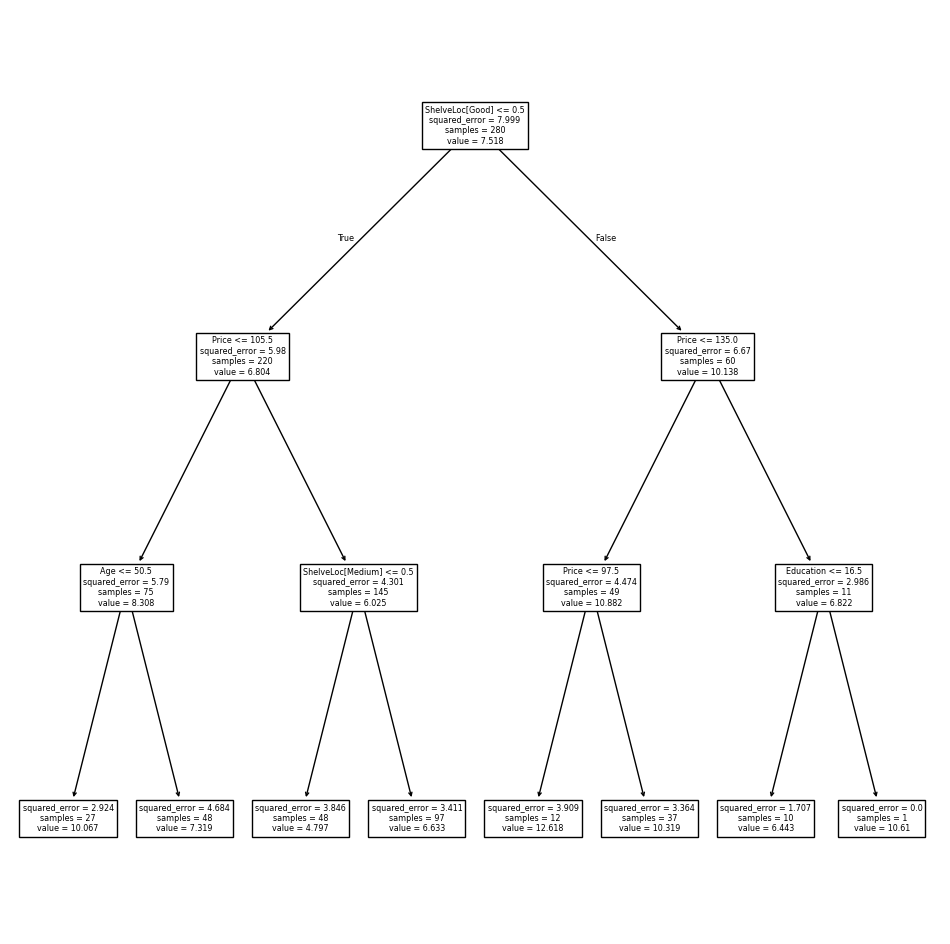

In [11]:
from sklearn.tree import (DecisionTreeClassifier as DTC,
                          DecisionTreeRegressor as DTR,
                          plot_tree,
                          export_text)
import matplotlib.pyplot as plt

tree = DTR(max_depth=3, random_state=1)
results = tree.fit(X_train,  y_train)
plt.figure().set_size_inches(12, 12)
plot_tree(results, 
          feature_names=feature_names);

In [13]:
print(np.mean((tree.predict(X_test) - y_test)**2))

4.725166009939633


(c) Use cross-validation in order to determine the optimal level of tree complexity. Does pruning the tree improve the test MSE?

In [14]:
kfold = skm.KFold(5,
                  shuffle=True,
                  random_state=2)

grid = skm.GridSearchCV(tree,
                        {'max_depth': np.arange(1, 20)},
                        refit=True,
                        cv=kfold,
                        scoring='neg_mean_squared_error')

G = grid.fit(X_train, y_train)
G.best_params_

{'max_depth': np.int64(3)}

In [15]:
ccp_path = G.best_estimator_.cost_complexity_pruning_path(X_train, y_train)

grid = skm.GridSearchCV(G.best_estimator_,
                        {'ccp_alpha': ccp_path.ccp_alphas},
                        refit=True,
                        cv=kfold,
                        scoring='neg_mean_squared_error')

G = grid.fit(X_train, y_train)
G.best_params_

{'ccp_alpha': np.float64(0.0)}

In [17]:
best_ = grid.best_estimator_
print(np.mean((y_test - best_.predict(X_test))**2))

4.725166009939633


(d) Use the bagging approach in order to analyze this data. What test MSE do you obtain? Use the <font color="brown">feature_importance_</font> values to determine which variables are most important.

##### Bagging

In [25]:
from sklearn.ensemble import \
     (RandomForestRegressor as RF,
      GradientBoostingRegressor as GBR,
      GradientBoostingClassifier as GBC)
import pandas as pd
import seaborn as sns

bagging_carseats = RF(n_estimators=500,
                      max_features=X_train.shape[1],
                      random_state=1).fit(X_train, y_train)
print(np.mean((bagging_carseats.predict(X_test) - y_test)**2))

2.845505824526674


We got a test **MSE** of 
 which is an improvement from the single regression tree.

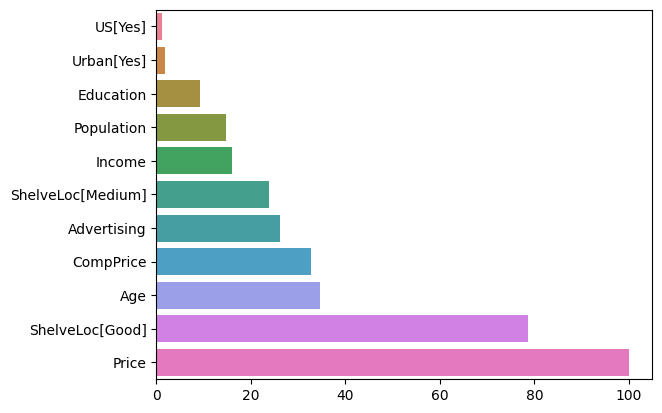

In [26]:
feature_imp = pd.DataFrame(
    {'importance':bagging_carseats.feature_importances_},
    index=feature_names)
sns.barplot(feature_imp.sort_values(by='importance').T * 100/feature_imp['importance'].max(), orient='h');

(e) Use random forests to analyze this data. What test MSE do you obtain? Use the <font color="brown">feature_importance_</font> values to determine which variables are most important. Describe the effect of m, the number of variables considered at each split, on the error rate obtained.

In [27]:
test_errors = []
best_rf = None
for m in np.arange(1, X_train.shape[1]+1):
    rf_carseats = RF(n_estimators=500,
                        max_features=m,
                        random_state=1).fit(X_train, y_train)
    
    error = np.mean((rf_carseats.predict(X_test) - y_test)**2)
    test_errors.append(error)
    
    if error == min(test_errors):
        best_rf = rf_carseats

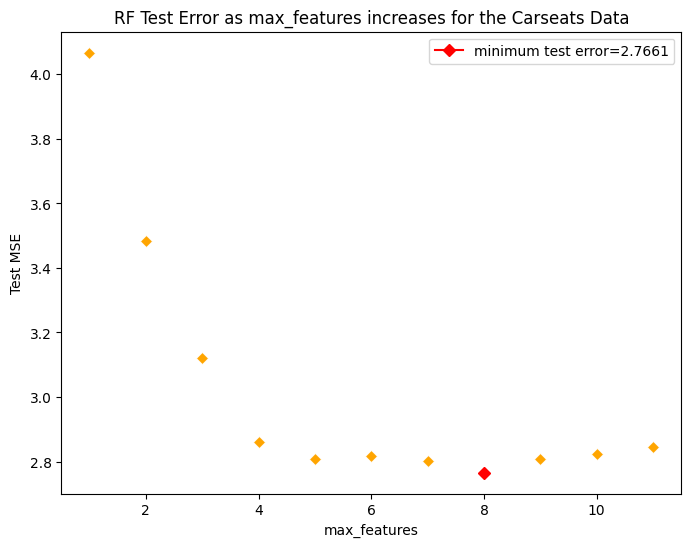

In [28]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(x=np.arange(1, X_train.shape[1]+1), y=test_errors, ax=ax, c='orange', marker='D')
ax.plot(np.argmin(test_errors)+1, min(test_errors), c='red', marker='D', label=f'minimum test error={min(test_errors):.4f}')
ax.set_title('RF Test Error as max_features increases for the Carseats Data', ha='center')
ax.set_xlabel('max_features')
ax.set_ylabel('Test MSE')
ax.legend();

We can see that the test error rapidly decreases as max_features goes down, stabilising at around but minimized at 
, we also notice that it rises up a bit after too.

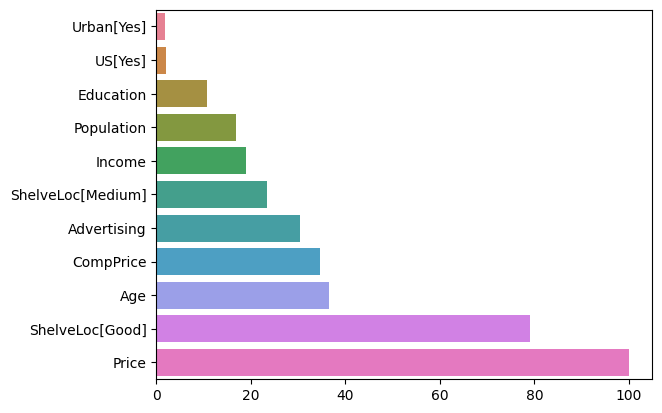

In [29]:
feature_imp = pd.DataFrame(
    {'importance':best_rf.feature_importances_},
    index=feature_names)
sns.barplot(feature_imp.sort_values(by='importance').T * 100/feature_imp['importance'].max(), orient='h');

(f) Now analyze the data using **BART**, and report your results.

***Sol.***

The **BART** method performed even better on this data than all the previous methods.

I plot the variable_inclusion means and scale them by which can serve as measures of importance here.

Again the model shows the Price and ShelveLoc[Good] variables.

In [31]:
from ISLP.bart import BART
bart_carseats = BART(random_state=0, burnin=100, ndraw=1000)
bart_carseats.fit(X_train, y_train)

,num_trees,200
,num_particles,10
,max_stages,5000
,split_prob,<function BAR...t 0x13338bb00>
,min_depth,0
,std_scale,2
,split_prior,None
,ndraw,1000
,burnin,100
,sigma_prior,"(5, ...)"
,num_quantile,50


In [32]:
np.mean((bart_carseats.predict(X_test) - y_test)**2)

np.float64(1.4032862543324849)

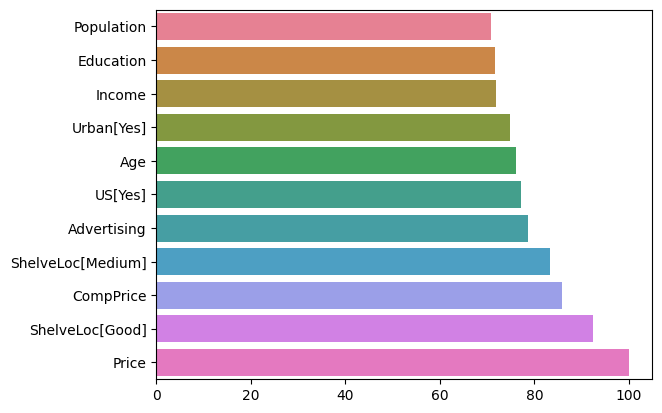

In [33]:
var_inclusion = pd.DataFrame(
    {'inclusion':bart_carseats.variable_inclusion_.mean(0)},
    index=D.columns)
sns.barplot(var_inclusion.sort_values(by='inclusion').T * (100 / var_inclusion['inclusion'].max()), orient='h');